## Combine BERT pred to train data 

In [2]:
import sagemaker
import boto3
import pandas as pd
import json
import csv
from tqdm import tqdm
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)
import string
from ast import literal_eval
import nltk
from sagemaker.huggingface import HuggingFace, HuggingFaceModel
from sagemaker.s3 import S3Uploader, S3Downloader, s3_path_join
import s3fs
import re
import numpy as np
import ast
#from utils import summarize_hpo_results

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [98]:
################################################
#loading train data
################################################
dfs = []
for load_num in tqdm(range (0,30)): #only loads in subset of data, can load full data later
    df = pd.read_json(f's3://sagemaker-studio-ai-lab-3/final-data/data_{load_num}.json') 
    dfs.append(df)

#concat dataset
reviews = pd.concat (dfs, ignore_index = True)

#loading BERT prediction data for train df
bert_pred = pd.read_csv(f's3://sagemaker-studio-ai-lab-3/samples/datasets/bert60k_predictions')

100%|██████████| 30/30 [05:22<00:00, 10.75s/it]


In [ ]:
bert_pred.head(1)

In [32]:
bert_pred.dropna(subset=['bert_pred'], inplace=True)

def extract_number(row_string):
    return ast.literal_eval(row_string)  # Convert string to dictionary

bert_pred['pred'] = bert_pred['bert_pred'].apply(extract_number)

bert_pred['pred'] = [int(entry['label'].split('_')[-1]) for entry in bert_pred['pred']]

In [ ]:
bert_subset = bert_pred[['review_id', 'pred']]

In [106]:
merged_df = pd.merge(reviews, bert_subset, on='review_id', how='left')
reviews = merged_df.head(300000)
reviews.dropna(inplace = True)

/tmp/ipykernel_21/2124743850.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews.dropna(inplace = True)


## Final Feature engineering

### category engineering

In [109]:
#Category feature engineering
restaurant_synonyms = [
    'Eatery',
    'Diner',
    'Café',
    'Bistro',
    'Brasserie',
    'Tavern',
    'Canteen',
    'Pub',
    'Joint',
    'Spot',
    'Establishment',
    'Venue',
    'Hostelry',
    'Inn',
    'Dive',
    'Chophouse',
    'Grill',
    'Buffet',
    'Cafeteria',
    'Tea Room',
    'Pizzeria',
    'Osteria',
    'Trattoria',
    'Steakhouse',
    'Boulangerie',
    'Patisserie',
    'Sushi Bar',
    'Tapas Bar',
    'Deli',
    'Fast Food Joint',
    'Drive-Thru',
    'Takeout',
    'Food Court',
    'Dining Room',
    'Gastropub',
    'Noodle House',
    'Catering Service',
    'Fine Dining Restaurant',
    'Casual Dining Place',
    'Family Restaurant',
    'Roadside Eatery',
    'Hole-in-the-Wall',
    'Bakery',
    'Coffeehouse',
    'Ice Cream Parlor',
    'Brewpub',
    'Cocktail Lounge',
    'Wine Bar',
    'Ristorante',
    'Food Truck',
    'Pop-Up Restaurant',
    'Brewery',
    'Tearoom',
    'Eat-out',
    'Gourmet Temple',
    'Dining Establishment',
    'Gathering Place',
    'Cookery',
    'Hash House',
    'Luncheonette',
    'Noshery',
    'Rotisserie',
    'Soupery',
    'Spirits Emporium',
    'Quisine Spot',
    'Tucker Joint',
    'Vittles Station',
    'Munchery',
    'Grub Hub',
    'Refreshment Stand',
    'Provender Palace',
    'Mangiare Mansion',
    'Sustenance Shack',
    'Restaurants',
    'restaurant',
    'bars',
    'food'
]
automotive_synonyms = [
    'Vehicle',
    'Automobile',
    'Auto',
    'Motorcar',
    'Car',
    'Machine',
    'Motor',
    'Technician',
    'Mechanic',
    'Motorized Vehicle',
    'Automobile Industry',
    'Motorcar Sector',
    'Automobile Manufacturing',
    'Automobile Engineering',
    'Motor Vehicle',
    'Motorcar Industry',
    'Car Industry',
    'Car Manufacturing',
    'Automobile Sector',
    'Auto Industry',
    'Auto Manufacturing',
    'Car Business',
    'Car Maker',
    'Automaker',
    'Vehicle Manufacturer',
    'Car Company',
    'Auto Company',
    'Car Manufacturer',
    'Vehicle Producer',
    'Automobile Maker',
    'Auto Manufacturer',
    'Car Builder',
    'Auto Builder',
    'Mechanical',
    'Technical',
    'Engineering',
    'Machine Works',
    'Auto Repair',
    'Vehicle Repair',
    'Car Service',
    'Auto Service',
    'Vehicle Maintenance',
    'Car Care',
    'Automobile Service',
    'Mechanical Repair',
    'Auto Workshop',
    'Vehicle Workshop',
    'Car Workshop',
    'Auto Shop',
    'Car Shop',
    'Vehicle Shop',
    'Mechanic',
    'Auto Technician',
    'Car Technician',
    'Automotive Technician',
    'Auto Mechanic',
    'Car Mechanic',
    'Vehicle Mechanic',
    'Automobile Mechanic',
    'Auto Engineer',
    'Car Engineer',
    'Automotive Engineer',
    'Vehicle Engineer',
    'Car Expert',
    'Vehicle Expert',
    'Automobile Expert',
    'Auto Specialist',
    'Car Specialist',
    'Vehicle Specialist',
    'Automotive Specialist',
    'Car Enthusiast',
    'Auto Enthusiast',
    'Vehicle Enthusiast',
    'Automobile Enthusiast',
    'Automotive'
]
government_terms = [
    'Executive Branch',
    'Legislative Branch',
    'Judicial Branch',
    'Congress',
    'Senate',
    'House of Representatives',
    'Supreme Court',
    'Cabinet',
    'Ambassador',
    'Diplomat',
    'Embassy',
    'Consulate',
    'Constitution',
    'Bill',
    'Law',
    'Amendment',
    'Budget',
    'Bureaucracy',
    'Civil Service',
    'Election',
    'Voter',
    'Primary Election',
    'General Election',
    'Campaign',
    'Political Party',
    'Democracy',
    'Republic',
    'Monarchy',
    'Dictatorship',
    'Oligarchy',
    'Federalism',
    'State',
    'Local Government',
    'Town Hall',
    'Public Policy',
    'Foreign Policy',
    'Domestic Policy',
    'National Security',
    'Homeland Security',
    'Intelligence Community',
    'Diplomacy',
    'Executive Order',
    'Ombudsman',
    'Constituency',
    'Constituent',
    'Bipartisanship',
    'Gerrymandering',
    'Lobbyist',
    'Political Action Committee (PAC)',
    'Civic Engagement',
    'Census',
    'Eminent Domain',
    'Foreign Aid',
    'Infrastructure',
    'Social Security',
    'Medicare',
    'Medicaid',
    'Welfare',
    'Public Service',
    'Public Administration',
    'Policy Analyst',
    'Statecraft',
    'Nationalism',
    'Patriotism',
    'Separation of Powers',
    'Checks and Balances',
    'Rule of Law',
    'Human Rights',
    'Constitutional Rights',
    'Civil Liberties',
    'Citizenship',
    'Immigration',
    'Naturalization',
    'Veto',
    'Override',
    'Filibuster',
    'Civic Duty',
    'Cabinet Meeting',
    'Press Secretary',
    'Census Bureau',
    'Homeland Defense',
    'Legislation',
    'Oversight',
    'Policy'
]
clothing_terms = [
    'Fashion',
    'Style',
    'Trend',
    'Accessories',
    'Fabric',
    'Textile',
    'Stitching',
    'Sewing',
    'Pattern',
    'Silhouette',
    'Hem',
    'Seam',
    'Lapel',
    'Collar',
    'Cuff',
    'Pleat',
    'Ruffle',
    'Embroidery',
    'Fashion Show',
    'Model',
    'Mannequin',
    'Photographer',
    'Editorial',
    'Street Style',
    'Fashion Blogger',
    'Style Icon',
    'Fashionista',
    'Accessory',
    'Footwear',
    'Apparel',
    'Textile Industry',
    'Fashion Forward',
    'Vintage',
    'Couture',
    'Tailoring',
    'Dressmaker',
    'Garment',
    'clothes',
    'clothing'
]

clothing_terms = [item.lower() for item in clothing_terms]
government_terms = [item.lower() for item in government_terms]
automotive_synonyms = [item.lower() for item in automotive_synonyms]
restaurant_synonyms = [item.lower() for item in restaurant_synonyms]

# Making all items in categories column lower case
reviews['b_categories'] = reviews['b_categories'].str.lower()

# Converting all items in categories column to lists
reviews['b_categories'] = reviews['b_categories'].str.split(",")

# Function to trim whitespaces from each item in the list
def trim_whitespace(lst):
    return [item.strip() if item is not None else None for item in (lst or [])]

# Apply the function to each row in the DataFrame
reviews['b_categories'] = reviews['b_categories'].apply(trim_whitespace)

# Add a 'food service' column and initialize it to 0
reviews['food_service'] = 0

# Function to check if any item in the list is present in list_two
def acheck_for_match(lst):
    if lst is not None:
        return any(item in restaurant_synonyms for item in lst)
    return False

# Apply the function to each row in the DataFrame
reviews['food_service'] = reviews['b_categories'].apply(acheck_for_match)
# Add a 'Auto Industry' column and initialize it to 0
reviews['auto_industry'] = 0

# Function to check if any item in the list is present in list_two
def bcheck_for_match(lst):
    if lst is not None:
        return any(item in automotive_synonyms for item in lst)
    return False

# Apply the function to each row in the DataFrame
reviews['auto_industry'] = reviews['b_categories'].apply(bcheck_for_match)

# Add a 'Government' column and initialize it to 0
reviews['government_terms'] = 0

# Function to check if any item in the list is present in list_two
def ccheck_for_match(lst):
    if lst is not None:
        return any(item in government_terms for item in lst)
    return False

# Apply the function to each row in the DataFrame
reviews['government_terms'] = reviews['b_categories'].apply(ccheck_for_match)

# Add a 'Government' column and initialize it to 0
reviews['clothing_terms'] = 0

# Function to check if any item in the list is present in list_two
def dcheck_for_match(lst):
    if lst is not None:
        return any(item in clothing_terms for item in lst)
    return False

# Apply the function to each row in the DataFrame
reviews['clothing_terms'] = reviews['b_categories'].apply(dcheck_for_match)

reviews['food_service'] = reviews['food_service'].astype(int)
reviews['clothing_terms'] = reviews['clothing_terms'].astype(int)
reviews['government_terms'] = reviews['government_terms'].astype(int)
reviews['auto_industry'] = reviews['auto_industry'].astype(int)

/tmp/ipykernel_21/753629848.py:292: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['b_categories'] = reviews['b_categories'].str.lower()
/tmp/ipykernel_21/753629848.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['b_categories'] = reviews['b_categories'].str.split(",")
/tmp/ipykernel_21/753629848.py:302: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [110]:
#Adding frequency of user_id count field
reviews['review_count'] = reviews.groupby('user_id')['user_id'].transform('count')
reviews['business_count'] = reviews.groupby('business_id')['business_id'].transform('count')

/tmp/ipykernel_21/1636987764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['review_count'] = reviews.groupby('user_id')['user_id'].transform('count')
/tmp/ipykernel_21/1636987764.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['business_count'] = reviews.groupby('business_id')['business_id'].transform('count')


In [111]:
#ATTRIBUTE feature engineering 
#booleans for number of trues and number of attributes
def count_true_values(attribute_dict):
    if attribute_dict is not None:
        return sum(1 for value in attribute_dict.values() if value.lower() == 'true')
    else:
        return 0 
reviews['attribute_num'] = reviews['b_attributes'].apply(lambda x: len(x) if x is not None else 0)
reviews['attribute_true_count'] = reviews['b_attributes'].apply(count_true_values)

#attribute boolean for alcohol (general form can be used for other categories)
def extract_alcohol(item):
    if isinstance(item, dict) and 'Alcohol' in item and item['Alcohol'] != u'none' and item['Alcohol'] != 'none' and item['Alcohol'] != None:
        return 1
    else:
        return 0  
reviews['att_alc'] = reviews['b_attributes'].apply(extract_alcohol)

#attribute boolean for kids (general form can be used for other categories)
def extract_kids(item):
    if isinstance(item, dict) and 'GoodForKids' in item and item['GoodForKids'] != u'none' and item['GoodForKids'] != 'none' and item['GoodForKids'] != None:
        return 1
    else:
        return 0  
reviews['att_kid'] = reviews['b_attributes'].apply(extract_kids)

#attribute boolean for tv 
def extract_tv(item):
    if isinstance(item, dict) and 'HasTV' in item and item['HasTV'] != u'none' and item['HasTV'] != 'none' and item['HasTV'] != None:
        return 1
    else:
        return 0 
reviews['att_tv'] = reviews['b_attributes'].apply(extract_tv)

#attribute boolean for reservations
def extract_res(item):
    if isinstance(item, dict) and 'RestaurantsReservations' in item and item['RestaurantsReservations'] != u'none' and item['RestaurantsReservations'] != 'none' and item['RestaurantsReservations'] != None:
        return 1
    else:
        return 0  
reviews['att_res'] = reviews['b_attributes'].apply(extract_res)

#attribute boolean for wheelchair assistence
def extract_wheel(item):
    if isinstance(item, dict) and 'WheelchairAccessible' in item and item['WheelchairAccessible'] != u'none' and item['WheelchairAccessible'] != 'none' and item['WheelchairAccessible'] != None:
        return 1
    else:
        return 0  
reviews['att_wheel'] = reviews['b_attributes'].apply(extract_wheel)

#attribute boolean for catering
def extract_cater(item):
    if isinstance(item, dict) and 'Caters' in item and item['Caters'] != u'none' and item['Caters'] != 'none' and item['Caters'] != None:
        return 1
    else:
        return 0 
reviews['att_cater'] = reviews['b_attributes'].apply(extract_cater)

/tmp/ipykernel_21/2098985199.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['attribute_num'] = reviews['b_attributes'].apply(lambda x: len(x) if x is not None else 0)
/tmp/ipykernel_21/2098985199.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['attribute_true_count'] = reviews['b_attributes'].apply(count_true_values)
/tmp/ipykernel_21/2098985199.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [ ]:
# reviews.b_categories[0:10000].value_counts()

In [ ]:
# correlation_matrix = reviews.corr()
# plt.figure(figsize=(12, 10))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Correlation Heatmap")
# plt.show()

In [ ]:
# pd.set_option('display.max_colwidth', 50)
# pd.set_option('display.max_columns', None)
# reviews.head(1)

### duplicate text fields

In [ ]:
# # Number of duplicate records
# duplicates_count = sum(reviews[['r_text']].duplicated())

# # Find the duplicate texts in the records
# duplicates = reviews[reviews[['r_text']].duplicated()]

# # Display the duplicated reviews (sorted)
# filtered_reviews = reviews[reviews['r_text'].str.lower().isin(duplicates['r_text'].str.lower())]

# print(f"There are a total of {duplicates_count} duplicate values. Run the next cell to remove them")
# filtered_reviews.head(5).sort_values(by = 'r_text')

### date related fields

In [ ]:
# # Creating new columns that have the date, year, month and weekday based on r_date
# fti_r_date = pd.to_datetime(reviews['r_date'], unit='ms')
# reviews['fti_r_date'] = fti_r_date
# reviews['fti_r_year'] = fti_r_date.dt.year 
# reviews['fti_r_month'] = fti_r_date.dt.month
# reviews['fti_r_weekday'] = fti_r_date.dt.strftime('%A')
# reviews.head(1)

### location related fields

In [112]:
# Loading Data from External Sources
zip_codes = pd.read_csv('zip_code_database.csv', dtype = str)[['zip', 'primary_city', 'state', 'irs_estimated_population']]
states_regions = pd.read_csv('states_regions.csv', dtype = str)
zip_codes = zip_codes.merge(states_regions, left_on = 'state', right_on = 'State.1', how='left')
zip_codes = zip_codes.drop(columns=['State.1'])
zip_codes = zip_codes.rename(columns={"zip": "zip", 
                   "primary_city": "city",
                   "state": "state",
                   "irs_estimated_population": "population",
                   "State": "state_name",
                   "Region": "region", 
                   "Division": "division", 
                  })
# The final dataset to be merged with the main dataframe
zip_codes.head(5)

,zip,city,state,population,state_name,region,division
0,00501,Holtsville,NY,562,New York,Northeast,Middle Atlantic
1,00544,Holtsville,NY,0,New York,Northeast,Middle Atlantic
2,00601,Adjuntas,PR,0,Puerto Rico,Other,Other
3,00602,Aguada,PR,0,Puerto Rico,Other,Other
4,00603,Aguadilla,PR,0,Puerto Rico,Other,Other


In [113]:
# Merging the main dataframe with zip_codes using the b_postal_code 
reviews = reviews.merge(zip_codes, left_on = 'b_postal_code', right_on = 'zip', how='left')
weird_zips = reviews[reviews['b_postal_code'] != reviews['zip']].shape[0]
print(f"There are a total of {weird_zips} postal codes that have a weird format so we can drop them at the end.")
reviews.head(1)

There are a total of 4820 postal codes that have a weird format so we can drop them at the end.


,review_id,user_id,business_id,r_stars,r_useful,r_funny,r_text,r_date,r_name,b_postal_code,...,att_res,att_wheel,att_cater,zip,city,state,population,state_name,region,division
0,58vpFFj3ZlGlQCH_k6mahg,cPcStFGBlk-6lWWsttIfVQ,JLixvCikc5JYGcnvaqHoJg,4,3,2,It's a basic speakeasy bar that's more low key...,1451950757000,21st Amendment at La Louisiane,70130,...,1,0,1,70130,New Orleans,LA,9410,Louisiana,South,West South Central


### new features extracted from r_text column

In [114]:
stopwords = nltk.corpus.stopwords.words('english')
punctuation_symbols = '[' + string.punctuation + ']'

reviews['n_char'] = reviews['r_text'].apply(lambda x: len(x) - x.count(" "))
reviews['stopword_count'] = reviews['r_text'].apply(lambda x: len([word for word in x.split() if word.lower() in stopwords]))
reviews['n_words'] = reviews['r_text'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
reviews['n_exclamations'] = reviews['r_text'].str.count('!')
reviews['symbol_count'] = reviews['r_text'].str.count(punctuation_symbols)

### More locaion related fiels

In [115]:
# Create a new column for unique businesses per zipcode
reviews['n_businesses_perzip'] = reviews.groupby('zip')['business_id'].transform('nunique')

# Create a new column for unique businesses per city
reviews['n_businesses_percity'] = reviews.groupby('city')['business_id'].transform('nunique')

# Create a new column for number of categories that the review belongs to 
reviews['n_categories'] = reviews['b_categories'].apply(lambda x: len(x))

reviews.head(1)

,review_id,user_id,business_id,r_stars,r_useful,r_funny,r_text,r_date,r_name,b_postal_code,...,region,division,n_char,stopword_count,n_words,n_exclamations,symbol_count,n_businesses_perzip,n_businesses_percity,n_categories
0,58vpFFj3ZlGlQCH_k6mahg,cPcStFGBlk-6lWWsttIfVQ,JLixvCikc5JYGcnvaqHoJg,4,3,2,It's a basic speakeasy bar that's more low key...,1451950757000,21st Amendment at La Louisiane,70130,...,South,West South Central,533,52,117,0,19,117.0,479.0,2


In [ ]:
# # Create a column to categorize based on time 
# # Define the conditions
# pre_covid = reviews['fti_r_date'] < pd.Timestamp('2020-03-01')
# covid = (pd.Timestamp('2020-03-01') <= reviews['fti_r_date']) & (reviews['fti_r_date'] <= pd.Timestamp('2021-06-30'))
# post_covid = reviews['fti_r_date'] > pd.Timestamp('2021-06-30')

# # Assign the categories based on conditions
# reviews['covid_timeline'] = np.select([pre_covid, covid, post_covid],
#                                          ['pre_covid', 'covid', 'post_covid'], default='unknown')

In [ ]:
# reviews = pd.get_dummies(reviews, prefix = ['covid','year', 'month', 'weekday', 'region', 'div'], columns = ['covid_timeline','fti_r_year', 'fti_r_month', 'fti_r_weekday', 'region', 'division'])
# reviews.head(5)

In [ ]:
#STOP HERE

### DROPPING columns / REMOVING values

Variables to keep: 'stopword_count','review_count', 'n_char', 'n_exclamations','business_count', 'symbol_count','population','n_businesses_perzip','attribute_num', 'n_businesses_percity', 'attribute_true_count', 'n_categories','r_useful', 'r_funny'

In [118]:
reviews.head(1)

,review_id,user_id,business_id,r_stars,r_useful,r_funny,r_text,r_date,r_name,b_postal_code,...,region,division,n_char,stopword_count,n_words,n_exclamations,symbol_count,n_businesses_perzip,n_businesses_percity,n_categories
0,58vpFFj3ZlGlQCH_k6mahg,cPcStFGBlk-6lWWsttIfVQ,JLixvCikc5JYGcnvaqHoJg,4,3,2,It's a basic speakeasy bar that's more low key...,1451950757000,21st Amendment at La Louisiane,70130,...,South,West South Central,533,52,117,0,19,117.0,479.0,2


In [117]:
# Final column names for reviews dataset
reviews_for_modeling = reviews[['r_stars','pred','stopword_count','review_count', 'n_char', 'n_exclamations','business_count', 'symbol_count',
                   'population','n_businesses_perzip','attribute_num', 'n_businesses_percity', 'attribute_true_count', 
                   'n_categories','r_useful', 'r_funny']]

In [119]:
# New dataset that only has numerical columns
reviews_for_modeling['r_stars'] = reviews_for_modeling['r_stars'].astype('category')
reviews_for_modeling.head(5)

/tmp/ipykernel_21/2230993886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_for_modeling['r_stars'] = reviews_for_modeling['r_stars'].astype('category')


,r_stars,pred,stopword_count,review_count,n_char,n_exclamations,business_count,symbol_count,population,n_businesses_perzip,attribute_num,n_businesses_percity,attribute_true_count,n_categories,r_useful,r_funny
0,4,3.0,52,4,533,0,219,19,9410,117.0,19,479.0,4,2,3,2
1,4,4.0,49,14,420,2,55,16,50470,15.0,5,25.0,2,2,0,0
2,4,4.0,36,3,357,4,50,12,28590,14.0,24,14.0,10,4,2,0
3,5,5.0,49,1,455,0,644,17,31820,23.0,22,505.0,8,8,0,0
4,4,4.0,32,1,296,0,296,6,2980,39.0,25,390.0,6,8,0,0


In [122]:
print(reviews_for_modeling.columns[reviews_for_modeling.isnull().any()]) #drop nulls
print(reviews_for_modeling.info())
reviews_for_modeling.dropna(inplace = True)

Index(['population', 'n_businesses_perzip', 'n_businesses_percity'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278854 entries, 0 to 278853
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   r_stars               278854 non-null  category
 1   pred                  278854 non-null  float64 
 2   stopword_count        278854 non-null  int64   
 3   review_count          278854 non-null  int64   
 4   n_char                278854 non-null  int64   
 5   n_exclamations        278854 non-null  int64   
 6   business_count        278854 non-null  int64   
 7   symbol_count          278854 non-null  int64   
 8   population            274034 non-null  object  
 9   n_businesses_perzip   274034 non-null  float64 
 10  attribute_num         278854 non-null  int64   
 11  n_businesses_percity  274034 non-null  float64 
 12  attribute_true_count  278854 non-null  int64   
 13  n_ca

/tmp/ipykernel_21/53148050.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_for_modeling.dropna(inplace = True)


In [127]:
#UPLOAD full train dataset with bert pred and all feature engineering to s3
pred_upload_path = f"s3://sagemaker-studio-ai-lab-3/samples/datasets/300k_train_df_forsvmmodel"
reviews_for_modeling.to_csv(pred_upload_path, index = False)

## Visualizations

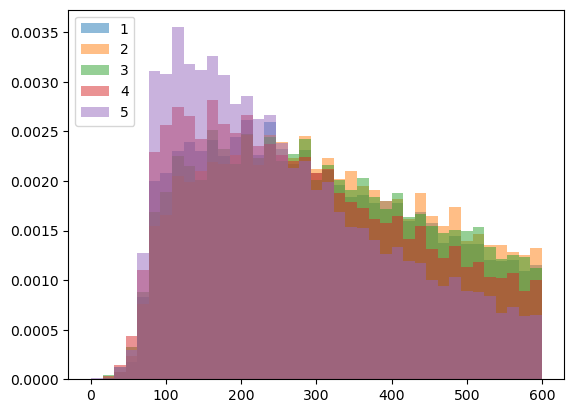

In [286]:
bins = np.linspace(0, 600, 40)
feature = 'n_char'

plt.hist(reviews[reviews['r_stars']== 1 ][feature], bins, alpha=0.5, density=True, label= 1 )
plt.hist(reviews[reviews['r_stars']== 2 ][feature], bins, alpha=0.5, density=True, label= 2 )
plt.hist(reviews[reviews['r_stars']== 3 ][feature], bins, alpha=0.5, density=True, label= 3 )
plt.hist(reviews[reviews['r_stars']== 4 ][feature], bins, alpha=0.5, density=True, label= 4 )
plt.hist(reviews[reviews['r_stars']== 5 ][feature], bins, alpha=0.5, density=True, label= 5 )


plt.legend(loc='upper left')
plt.show()

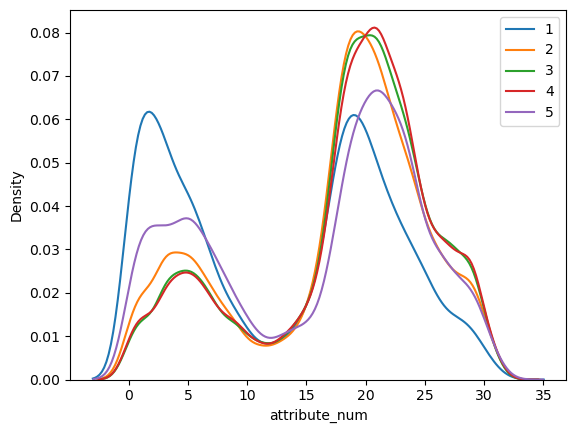

In [293]:
# Set up the figure and axis
reviews['population'].astype(int)
fig, ax = plt.subplots()
feature = 'attribute_num'

# Plot KDE for each star rating
sns.kdeplot(reviews[reviews['r_stars']==1][feature], label=1, ax=ax)
sns.kdeplot(reviews[reviews['r_stars']==2][feature], label=2, ax=ax)
sns.kdeplot(reviews[reviews['r_stars']==3][feature], label=3, ax=ax)
sns.kdeplot(reviews[reviews['r_stars']==4][feature], label=4, ax=ax)
sns.kdeplot(reviews[reviews['r_stars']==5][feature], label=5, ax=ax)

# Add legend
ax.legend()

# Show the plot
plt.show()

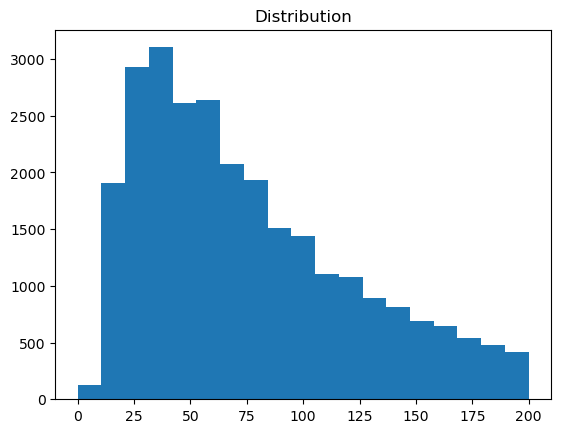

In [296]:
bins = np.linspace(0, 200, 20)

plt.hist(reviews['n_words'], bins)
plt.title("Distribution")
plt.show()

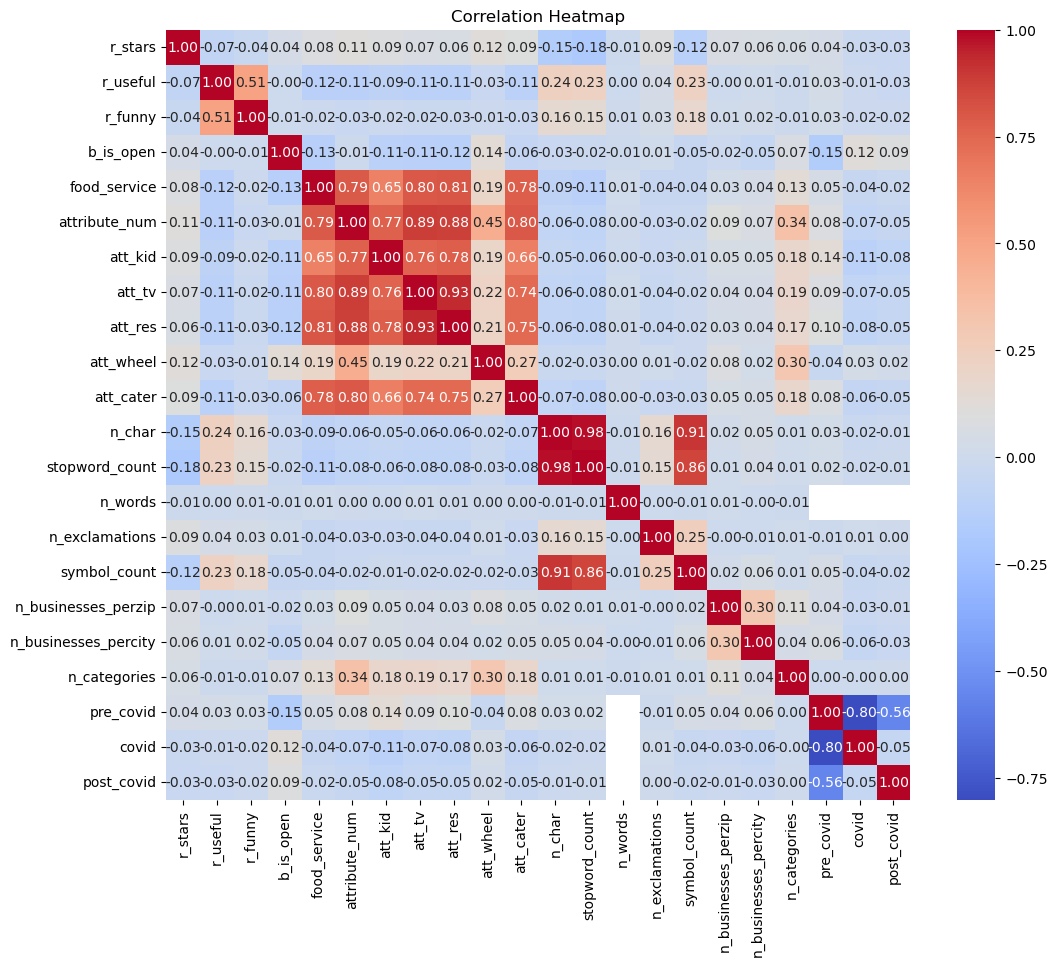

In [294]:
correlation_matrix = reviews[['r_stars', 'r_useful', 'r_funny',
       'b_is_open',
        'food_service', 'attribute_num' ,
       
       'att_kid', 'att_tv', 'att_res', 'att_wheel', 'att_cater', 
       'population',  'n_char',
       'stopword_count', 'n_words', 'n_exclamations', 'symbol_count',
       'n_businesses_perzip', 'n_businesses_percity', 'n_categories',
       'pre_covid', 'covid', 'post_covid' ]].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()